# Image augmentation tester

In [1]:
import glob
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import argparse
import random
import os, sys
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models

from sklearn import preprocessing
sys.path.append('./') # import를 위해 경로추가
from Modules import Utility as U
from Modules import CustomDataset 
from Modules import SmartCrop
from Modules import SmartPad

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--batch_size', type=int, default=4)
parser.add_argument('--seed', type=int, default=999)
parser.add_argument('--img_size', type=int, default=512)
parser.add_argument('--data_path', type=str, default='./data/')

args = parser.parse_args('')
args

Namespace(batch_size=4, data_path='./data/', img_size=512, seed=999)

In [3]:
U.seed_everything(args.seed)

In [4]:
df = pd.read_csv(args.data_path+'train_repaired.csv')
le = preprocessing.LabelEncoder()
df['artist'] = le.fit_transform(df['artist'].values)
train_df, val_df, _, _ = U.train_test_split(df, df['artist'].values, test_size=0.2, random_state=args.seed)
train_img_paths, train_labels = U.get_data(train_df)
val_img_paths, val_labels = U.get_data(val_df)

In [5]:
train_transform = A.Compose([
                            #SmartCrop(),
                            SmartPad(),
                            A.Resize(args.img_size, args.img_size),
                            A.HorizontalFlip(),
                            A.Rotate(10),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            #ToTensorV2()
                            ])

test_transform = A.Compose([
                            SmartCrop(),
                            A.Resize(args.img_size,args.img_size),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            #ToTensorV2()
                            ])

In [6]:
train_dataset = CustomDataset(args.data_path, train_img_paths, train_labels, train_transform)
train_loader = DataLoader(train_dataset, batch_size = args.batch_size, shuffle=True, num_workers=0)
iter_train = iter(train_loader)

val_dataset = CustomDataset(args.data_path, val_img_paths, val_labels, test_transform)
val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False, num_workers=0)
iter_val = iter(train_loader)


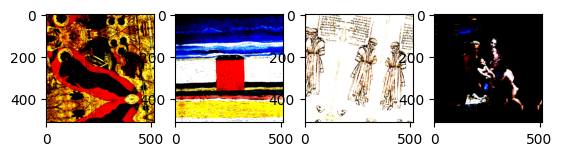

In [7]:
item = next(iter_train)
fig, ax = plt.subplots(1, args.batch_size)
for idx in range(args.batch_size):
    ax[idx].imshow(torch.clip(item['image'][idx],0,1))

In [8]:
temp_transform = A.Compose([
                            #SmartCrop(),
                            SmartPad(),
                            # A.RandomResizedCrop(height = args.img_size, 
                            #                     width = args.img_size,
                            #                     scale = (0.5,1)),
                            A.Resize(args.img_size, args.img_size),
                            A.HorizontalFlip(),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            #ToTensorV2()
                            ])

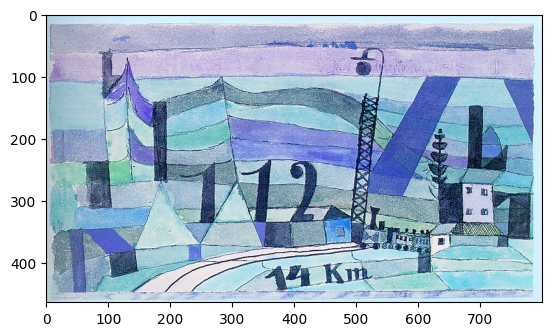

In [9]:
raw = cv2.imread(args.data_path + train_img_paths[32])
plt.imshow(raw)

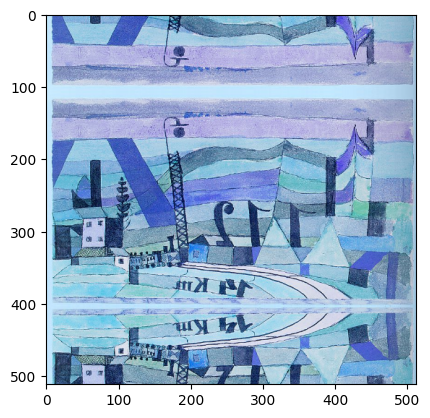

In [10]:
img = temp_transform(image=raw)['image']
imgnp = (img - np.min(img)) / (np.max(img) - np.min(img))
plt.imshow(imgnp)